In [35]:
import pandas as pd
import numpy as np
from sklearn.linear_model import LogisticRegression
from sklearn import preprocessing
from sklearn.metrics import log_loss, accuracy_score, confusion_matrix,recall_score,precision_recall_curve,auc,roc_curve,roc_auc_score,classification_report
from sklearn.model_selection import train_test_split
%matplotlib inline
import matplotlib.pyplot as plt
from sklearn.linear_model import Lasso
from sklearn.model_selection import KFold
from IPython import display
import seaborn as sns

In [2]:
data = pd.read_csv('data_classification.csv')
data.head(5)

,missedDeadlinesIndex,plagiarismRatio,sinner/saint
0,0.051267,0.69956,1
1,-0.092742,0.68494,1
2,-0.213710,0.69225,1
3,-0.375000,0.50219,1
4,-0.513250,0.46564,1


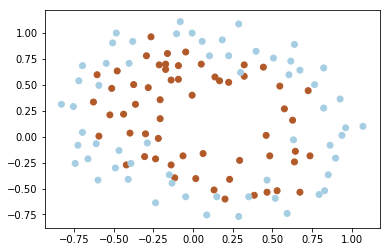

In [3]:
plt.scatter(data['missedDeadlinesIndex'], data['plagiarismRatio'], c=data['sinner/saint'], cmap=plt.cm.Paired)
plt.show()

In [4]:
x = data.loc[:, data.columns != 'sinner/saint']
y = data['sinner/saint']

In [5]:
def expand(x):
    x_expanded = np.zeros((x.shape[0], 6))
#     for i in range(x.shape[0]):
#         x_expanded[i] = [x.loc[i]['missedDeadlinesIndex'], x.loc[i]['plagiarismRatio'], x.loc[i]['missedDeadlinesIndex'] ** 2, x.loc[i]['plagiarismRatio'] ** 2, x.loc[i]['missedDeadlinesIndex'] * x.loc[i]['plagiarismRatio'], 1]
    if(type(x) == np.ndarray):
        for i in range(x.shape[0]):
            x_expanded[i] = [x[i][0], x[i][1], x[i][0] ** 2, x[i][1] ** 2, x[i][0] * x[i][1], 1]
    else:
        j = 0
        for i in x.index:
            x_expanded[j] = [x.loc[i]['missedDeadlinesIndex'], x.loc[i]['plagiarismRatio'], x.loc[i]['missedDeadlinesIndex'] ** 2, x.loc[i]['plagiarismRatio'] ** 2, x.loc[i]['missedDeadlinesIndex'] * x.loc[i]['plagiarismRatio'], 1]
            j += 1
    return x_expanded

In [6]:
def probability(X, w):
    return 1 / (1 + np.exp(-np.dot(X, w)))

In [7]:
def compute_loss(X, y, w):
    return np.sum(-(np.dot(y, np.log(probability(X, w))) + np.dot((1 - y), np.log(1 - probability(X, w))))) / X.shape[0]

In [8]:
def compute_loss_L1(X, y, w, lambd):
    return (np.sum(-(np.dot(y, np.log(probability(X, w))) + np.dot((1 - y), np.log(1 - probability(X, w))))) / X.shape[0]) + (lambd * np.sum(np.abs(w)) / (2 * X.shape[0]))

In [9]:
def compute_loss_L2(X, y, w, lambd):
    return (np.sum(-(np.dot(y, np.log(probability(X, w))) + np.dot((1 - y), np.log(1 - probability(X, w))))) / X.shape[0]) + (lambd * np.sum(w ** 2) / (2 * X.shape[0]))

In [10]:
def compute_grad(X, y, w):
    return np.dot(probability(X, w) - y, X) / X.shape[0]

In [11]:
def compute_grad_L1(X, y, w, lambd):
    return (np.dot(probability(X, w) - y, X) / X.shape[0]) + (lambd * np.sum(np.sign(w)) / (2 * X.shape[0]))

In [12]:
def compute_grad_L2(X, y, w, lambd):
    return (np.dot(probability(X, w) - y, X) / X.shape[0]) + (lambd * np.sum(w) / X.shape[0])

In [61]:
h = 0.01
x_min, x_max = x['missedDeadlinesIndex'].min() - 1, x['missedDeadlinesIndex'].max() + 1
y_min, y_max = x['plagiarismRatio'].min() - 1, x['plagiarismRatio'].max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))
x_expanded = expand(x)

def visualize(X, y, w, history):
    """draws classifier prediction with matplotlib magic"""
    Z = probability(expand(np.c_[xx.ravel(), yy.ravel()]), w)
    Z = Z.reshape(xx.shape)
    plt.subplot(1, 2, 1)
    plt.contourf(xx, yy, Z, alpha=0.8)
    plt.scatter(X[:, 0], X[:, 1], c=y, cmap=plt.cm.Paired)
    plt.xlim(xx.min(), xx.max())
    plt.ylim(yy.min(), yy.max())
    
    plt.subplot(1, 2, 2)
    plt.plot(history)
    plt.grid()
    ymin, ymax = plt.ylim()
    plt.ylim(0, ymax)
#     display.clear_output(wait=True)
    plt.show()

### Implementation of logistic regression from hw1 with L1 and L2 regularization

In [62]:
def compute(x, y, lambd=1, l='-'):
    # please use np.random.seed(42), eta=0.1, alpha=0.9, n_iter=100 and batch_size=4 for deterministic results
    x_expanded = expand(x)
    np.random.seed(42)

    w = np.array([0, 0, 0, 0, 0, 1.])

    eta = 0.1 # learning rate
    alpha = 0.9 # moving average of gradient norm squared
    eps = 1e-8

    n_iter = 1000
    batch_size = 6
    loss = np.zeros(n_iter)
    plt.figure(figsize=(12,5))
    for i in range(n_iter):
        ind = np.random.choice(x_expanded.shape[0], batch_size)
        if l == 'l1':
            loss[i] = compute_loss_L1(x_expanded, y, w, lambd)
        elif l == 'l2':
            loss[i] = compute_loss_L2(x_expanded, y, w, lambd)
        else:
            loss[i] = compute_loss(x_expanded, y, w)
    #     if i % 10 == 0:
    #         visualize(x_expanded[ind, :], y[ind], w, loss)

        # TODO: compute gradients, squared gradients, G, update weights
#         print("FRAUD", np.array(y)[[15, 17]])
        if l == 'l1':
            gg = compute_grad_L1(x_expanded[ind, :], np.array(y)[ind], w, lambd)
        elif l == 'l2':
            gg = compute_grad_L2(x_expanded[ind, :], np.array(y)[ind], w, lambd)
        else:
            gg = compute_grad(x_expanded[ind, :], np.array(y)[ind], w)
        G = ((1 - alpha) * (gg ** 2)) if i == 0 else alpha * G + ((1 - alpha) * (gg ** 2))
        w = w - gg * eta / (np.sqrt(G + eps))

    visualize(np.array(x), y, w, loss)
    plt.clf()
    return w, loss


In [63]:
def classifierPredict(theta,X):
    predictions = X.dot(theta)    
    return predictions > 0

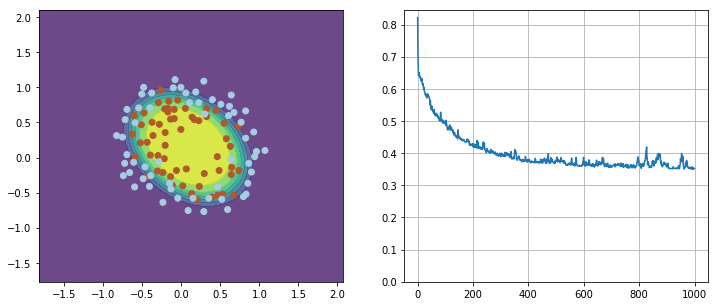


Train Accuracy: 49.152542372881356 %
Loss function: 0.3526098102869125


<Figure size 432x288 with 0 Axes>

In [64]:
w, loss = compute(x, y)

p=classifierPredict(w, expand(x))
print("\nTrain Accuracy:", (sum(p==y[:,np.newaxis])/len(y) *100)[0],"%")
print("Loss function:", loss[-1])

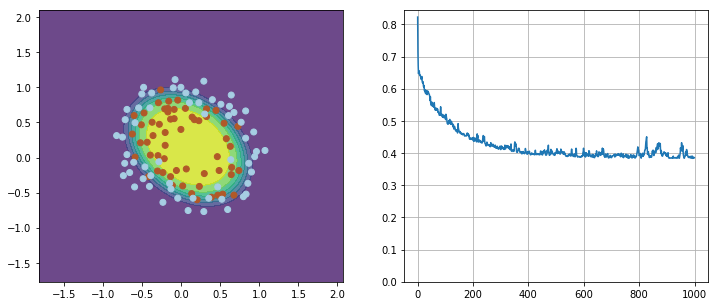


Train Accuracy(with L1): 49.152542372881356 %
Loss function(with L1): 0.38568894040996016


<Figure size 432x288 with 0 Axes>

In [65]:
w_l1, loss_l1 = compute(x, y, 0.2, 'l1')

p1=classifierPredict(w_l1, expand(x))
print("\nTrain Accuracy(with L1):", (sum(p1==y[:,np.newaxis])/len(y) *100)[0],"%")
print("Loss function(with L1):", loss_l1[-1])

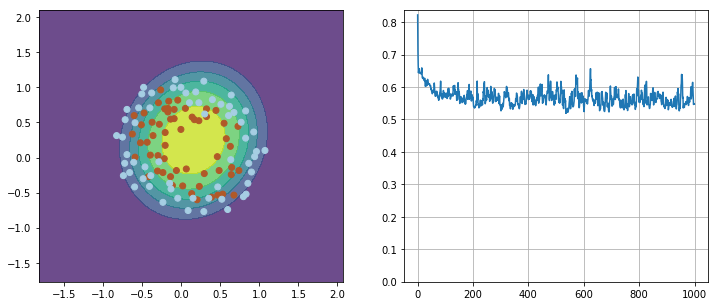


Train Accuracy(with L2): 49.152542372881356 %
Loss function(with L2): 0.547836489940357


<Figure size 432x288 with 0 Axes>

In [66]:
w_l2, loss_l2 = compute(x, y, 0.1, 'l2')

p2=classifierPredict(w_l2, expand(x))
print("\nTrain Accuracy(with L2):", (sum(p2==y[:,np.newaxis])/len(y) *100)[0],"%")
print("Loss function(with L2):", loss_l2[-1])

### sklearn implemented regularizations

In [67]:
sk_log_l1 = LogisticRegression(penalty='l1')
sk_log_l1.fit(x, y)
y_pred_l1 = sk_log_l1.predict(x)

/home/roman/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


In [68]:
sk_log_l2 = LogisticRegression(penalty='l2')
sk_log_l2.fit(x, y)
y_pred_l2 = sk_log_l2.predict(x)

/home/roman/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


In [69]:
print("\nTrain Accuracy(with L1):", accuracy_score(y, y_pred_l1) * 100, '%')
print("Loss function(with L1):", log_loss(y, y_pred_l1))
print("\nTrain Accuracy(with L2):", accuracy_score(y, y_pred_l2) * 100, '%')
print("Loss function(with L2):", log_loss(y, y_pred_l2))


Train Accuracy(with L1): 54.23728813559322 %
Loss function(with L1): 15.806070458078151

Train Accuracy(with L2): 54.23728813559322 %
Loss function(with L2): 15.806050129329927


In [75]:
def kfolder(lambd, l='-'):
    kf = KFold(n_splits=5)
    pred = np.zeros(len(y))
    for train_index, test_index in kf.split(x):
        x_train, x_test = x.iloc[train_index], x.iloc[test_index]
        y_train, y_test = y[train_index], y[test_index]
        w, loss = compute(x_train, y_train, lambd, l)
        p=classifierPredict(w, expand(x_test))
        pred[test_index] = p

    print("\nTrain Accuracy:", (sum(pred==y[:,np.newaxis])/len(y) *100)[0],"%")
    print("Loss function:", loss[-1])
    return pred

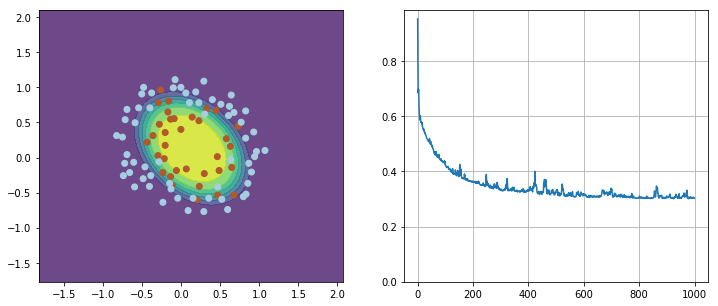

<Figure size 432x288 with 0 Axes>

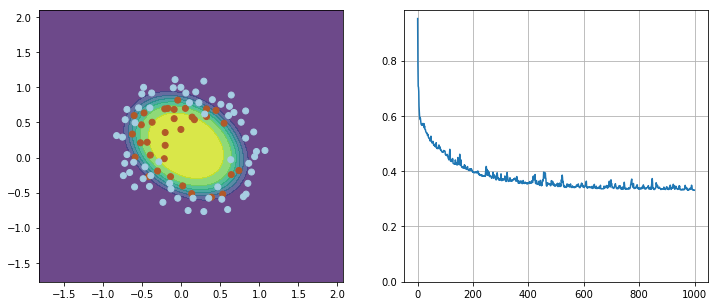

<Figure size 432x288 with 0 Axes>

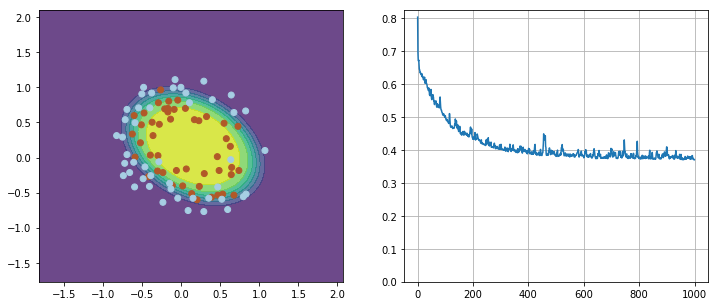

<Figure size 432x288 with 0 Axes>

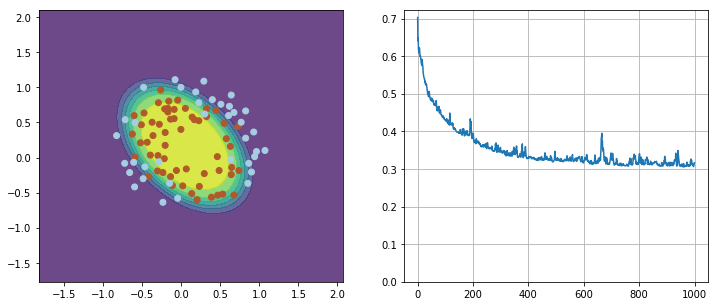

<Figure size 432x288 with 0 Axes>

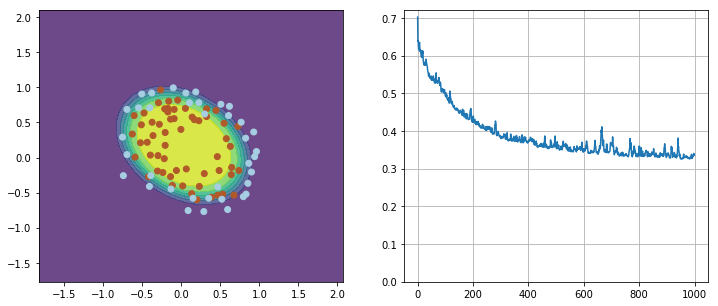


Train Accuracy: 49.152542372881356 %
Loss function: 0.336204800535183


<Figure size 432x288 with 0 Axes>

In [77]:
pr = kfolder(0.2)

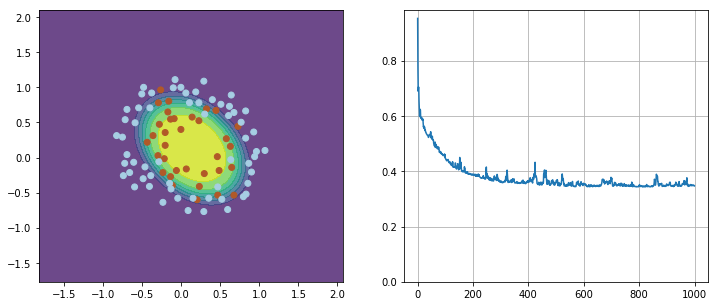

<Figure size 432x288 with 0 Axes>

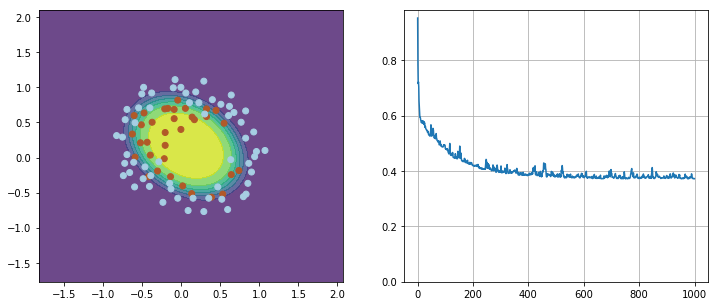

<Figure size 432x288 with 0 Axes>

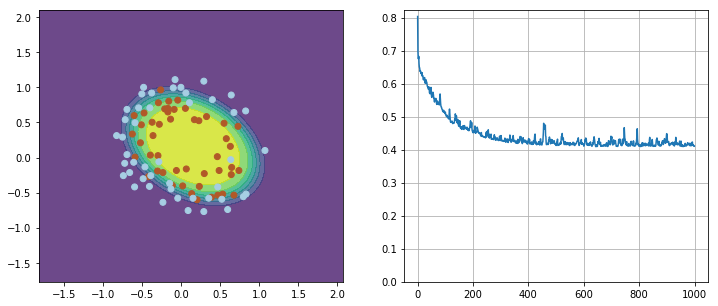

<Figure size 432x288 with 0 Axes>

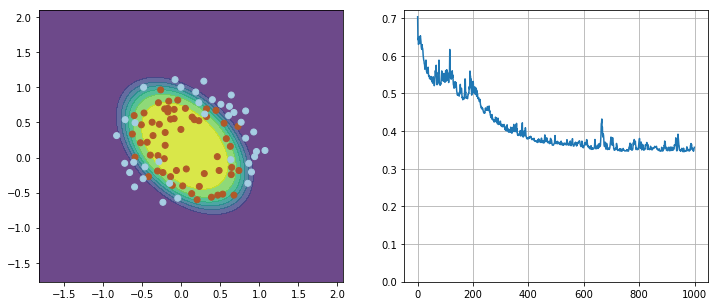

<Figure size 432x288 with 0 Axes>

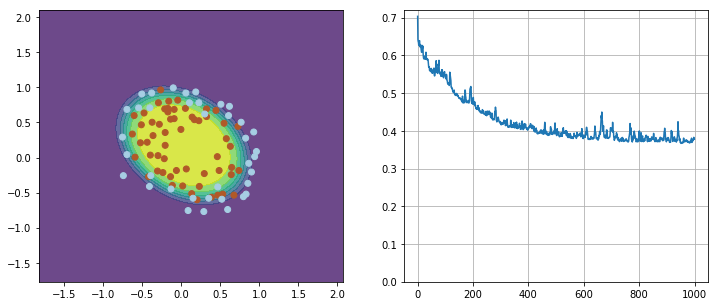


Train Accuracy: 49.152542372881356 %
Loss function: 0.3784726541318622


<Figure size 432x288 with 0 Axes>

In [78]:
pr1 = kfolder(0.2, 'l1')

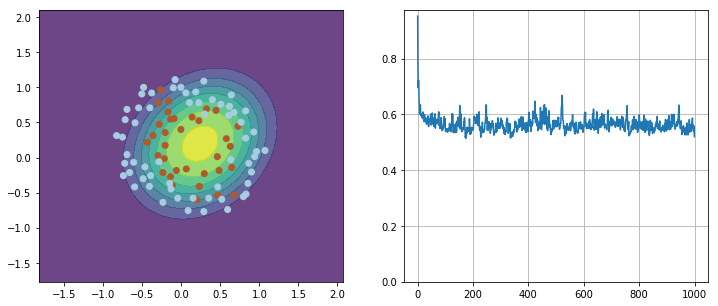

<Figure size 432x288 with 0 Axes>

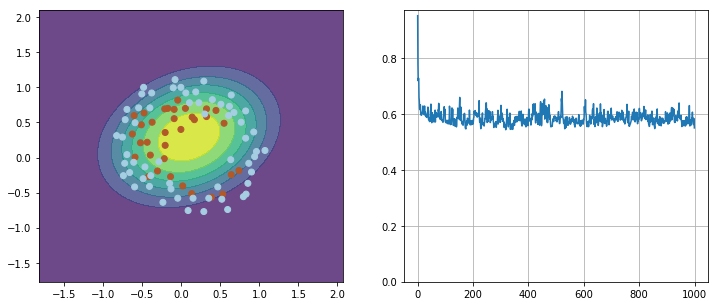

<Figure size 432x288 with 0 Axes>

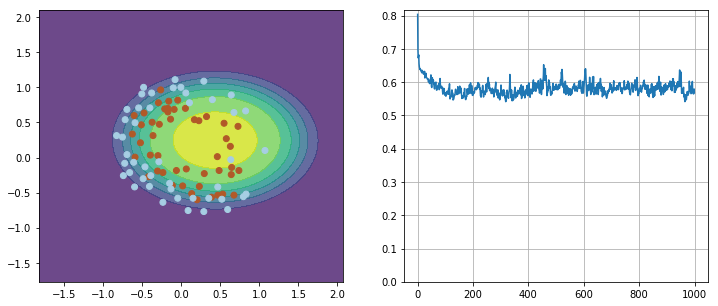

<Figure size 432x288 with 0 Axes>

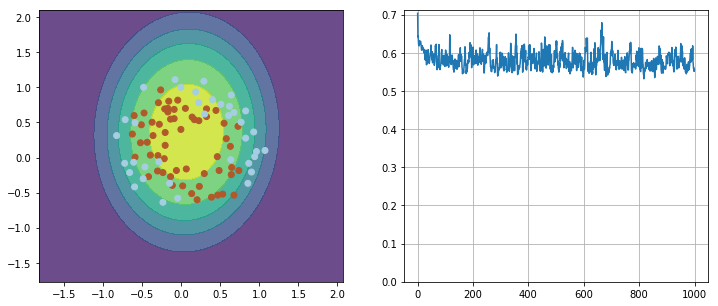

<Figure size 432x288 with 0 Axes>

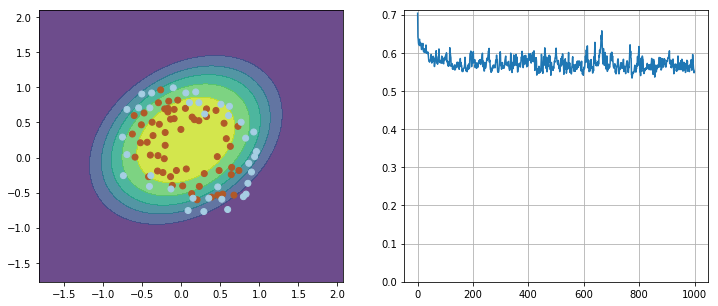


Train Accuracy: 49.152542372881356 %
Loss function: 0.5510825788569871


<Figure size 432x288 with 0 Axes>

In [79]:
pr2 = kfolder(0.2, 'l2')

In [80]:
def metrics(y, p, title=''):
    print("Accuracy Score:", accuracy_score(y, p))
    cnf_matrix=confusion_matrix(y,p)
    print("the recall for this model is :",cnf_matrix[1,1]/(cnf_matrix[1,1]+cnf_matrix[1,0]))
    print("log_loss:", log_loss(y, p))
    print("AUC:", roc_auc_score(y, p))
    print("ROC curve: ", roc_curve(y, p))
    fig= plt.figure(figsize=(6,3))# to plot the graph
    print("TP",cnf_matrix[1,1,]) # no of fraud transaction which are predicted fraud
    print("TN",cnf_matrix[0,0]) # no. of normal transaction which are predited normal
    print("FP",cnf_matrix[0,1]) # no of normal transaction which are predicted fraud
    print("FN",cnf_matrix[1,0]) # no of fraud Transaction which are predicted normal
    sns.heatmap(cnf_matrix,cmap="coolwarm_r",annot=True,linewidths=0.5)
    plt.title("Confusion matrix " + title)
    plt.xlabel("Predicted_class")
    plt.ylabel("Real class")
    plt.show()
    print("\n------Classification Report------")
    print(classification_report(y, p))
    print("________________________________________________________________________________________________________\n")

Accuracy Score: 0.6610169491525424
the recall for this model is : 0.6724137931034483
log_loss: 11.708202096122552
AUC: 0.6612068965517242
ROC curve:  (array([0.  , 0.35, 1.  ]), array([0.        , 0.67241379, 1.        ]), array([2., 1., 0.]))
TP 39
TN 39
FP 21
FN 19


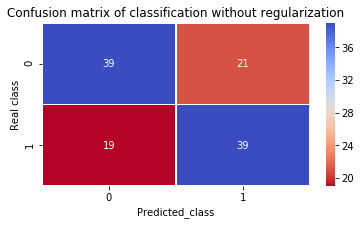


------Classification Report------
              precision    recall  f1-score   support

           0       0.67      0.65      0.66        60
           1       0.65      0.67      0.66        58

   micro avg       0.66      0.66      0.66       118
   macro avg       0.66      0.66      0.66       118
weighted avg       0.66      0.66      0.66       118

________________________________________________________________________________________________________



In [81]:
metrics(y, pr, 'of classification without regularization')

Accuracy Score: 0.6610169491525424
the recall for this model is : 0.6724137931034483
log_loss: 11.708202096122552
AUC: 0.6612068965517242
ROC curve:  (array([0.  , 0.35, 1.  ]), array([0.        , 0.67241379, 1.        ]), array([2., 1., 0.]))
TP 39
TN 39
FP 21
FN 19


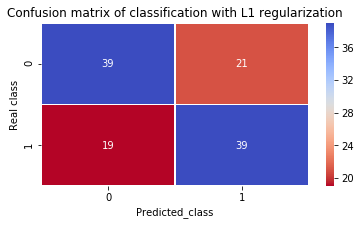


------Classification Report------
              precision    recall  f1-score   support

           0       0.67      0.65      0.66        60
           1       0.65      0.67      0.66        58

   micro avg       0.66      0.66      0.66       118
   macro avg       0.66      0.66      0.66       118
weighted avg       0.66      0.66      0.66       118

________________________________________________________________________________________________________



In [85]:
metrics(y, pr1, 'of classification with L1 regularization')

Accuracy Score: 0.288135593220339
the recall for this model is : 0.41379310344827586
log_loss: 24.587264381728872
AUC: 0.29022988505747127
ROC curve:  (array([0.        , 0.83333333, 1.        ]), array([0.       , 0.4137931, 1.       ]), array([2., 1., 0.]))
TP 24
TN 10
FP 50
FN 34


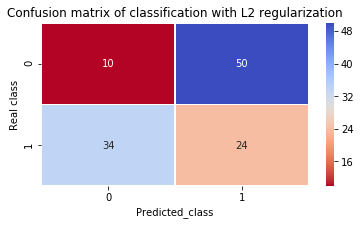


------Classification Report------
              precision    recall  f1-score   support

           0       0.23      0.17      0.19        60
           1       0.32      0.41      0.36        58

   micro avg       0.29      0.29      0.29       118
   macro avg       0.28      0.29      0.28       118
weighted avg       0.27      0.29      0.28       118

________________________________________________________________________________________________________



In [84]:
metrics(y, pr2, 'of classification with L2 regularization')

### Best result was achieved with L1 regularization